## Introduction
If users rate different items multiple times, and the same item is rated by different users, we can identify users with **similar preferences**. Valuable, because users with similar tastes in the past will likely have similar tastes in the future.\
Recommendation Engines (RE) are designed to suggest products or services to a user, exploiting the information provided by multiple users and/or the user's own feedback.

**Explicit Data**: direct feedback from a user $\rightarrow$ how they feel about a product (grade, upvote, ...).\
**Implicit Data**: uses the user's actions to summarize their preferences (users' historic choice, ...).

### 1. Non-personalized Recommendations
E.g.: "Frequently bought together" on Amazon.
Suggest something because it is not likely you will dislike the product, since it is very common.

This kind of engine can be built starting from a basic dataset exploration: let's take a book dataset, containing $n$ reviews by $m$ users (notice that it is not important *which* user). By simply averaging the ratings and taking only those books that have been rated more than 100 times (this number depends on the dimension of the dataset), we can assess which are the most common and appreciated books.

In [44]:
# Example on the movie lens dataset
import requests # to download the dataset
import zipfile # to extract the dataset
import io # to read the zip file
import pandas as pd
import numpy as np

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

response = requests.get(url) # download the dataset
response.raise_for_status() # check if the download was successful

# Create a ZipFile object from the response.content
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    print(zip_ref.namelist()) # list the files in the zip file
    # Read the useful files
    with zip_ref.open('ml-latest-small/ratings.csv') as file:
        ratings = pd.read_csv(file)
    with zip_ref.open('ml-latest-small/movies.csv') as file:
        movies = pd.read_csv(file)

['ml-latest-small/', 'ml-latest-small/links.csv', 'ml-latest-small/tags.csv', 'ml-latest-small/ratings.csv', 'ml-latest-small/README.txt', 'ml-latest-small/movies.csv']


In [45]:
# Swap the movieId with the title: use the merge method, which combines two dataframes
# The on parameter specifies the column to merge on (merging rule)
ratings = ratings.merge(movies[['movieId', 'title', 'genres']], on='movieId')

In [46]:
ratings.drop(columns=['movieId', 'timestamp'], inplace=True) # drop the timestamp and movieId columns

In [47]:
print(ratings.describe().round(2)) # show some statistics, rounded to 2 decimal places

          userId     rating
count  100836.00  100836.00
mean      326.13       3.50
std       182.62       1.04
min         1.00       0.50
25%       177.00       3.00
50%       325.00       3.50
75%       477.00       4.00
max       610.00       5.00


In [48]:
ratings.isna().sum() # check for missing values

userId    0
rating    0
title     0
genres    0
dtype: int64

In [49]:
ratings.isnull().sum() # check for missing values

userId    0
rating    0
title     0
genres    0
dtype: int64

In [50]:
# Perform the simple task of finding the average rating for each movie
average_ratings = ratings.groupby('title')['rating'].mean()
average_ratings.sort_values(ascending=False)

title
Gena the Crocodile (1969)                  5.0
True Stories (1986)                        5.0
Cosmic Scrat-tastrophe (2015)              5.0
Love and Pigeons (1985)                    5.0
Red Sorghum (Hong gao liang) (1987)        5.0
                                          ... 
Don't Look Now (1973)                      0.5
Journey 2: The Mysterious Island (2012)    0.5
Joe Dirt 2: Beautiful Loser (2015)         0.5
Jesus Christ Vampire Hunter (2001)         0.5
Fullmetal Alchemist 2018 (2017)            0.5
Name: rating, Length: 9719, dtype: float64

In [51]:
# Some of the movies may have been rated only few times and the statistics could be biased
ratings['title'].value_counts()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Sex, Drugs & Taxation (2013)          1
Extraordinary Tales (2015)            1
Tomorrow (2015)                       1
Embrace of the Serpent (2016)         1
31 (2016)                             1
Name: count, Length: 9719, dtype: int64

In [52]:
# Set a count threshold: we select 50 reviews to keep a quite large dataset
ratings = ratings.groupby('title').filter(lambda x: len(x) >= 50)
ratings['title'].value_counts()

title
Forrest Gump (1994)                                    329
Shawshank Redemption, The (1994)                       317
Pulp Fiction (1994)                                    307
Silence of the Lambs, The (1991)                       279
Matrix, The (1999)                                     278
                                                      ... 
Scary Movie (2000)                                      50
Harry Potter and the Deathly Hallows: Part 2 (2011)     50
You've Got Mail (1998)                                  50
Skyfall (2012)                                          50
Super Size Me (2004)                                    50
Name: count, Length: 450, dtype: int64

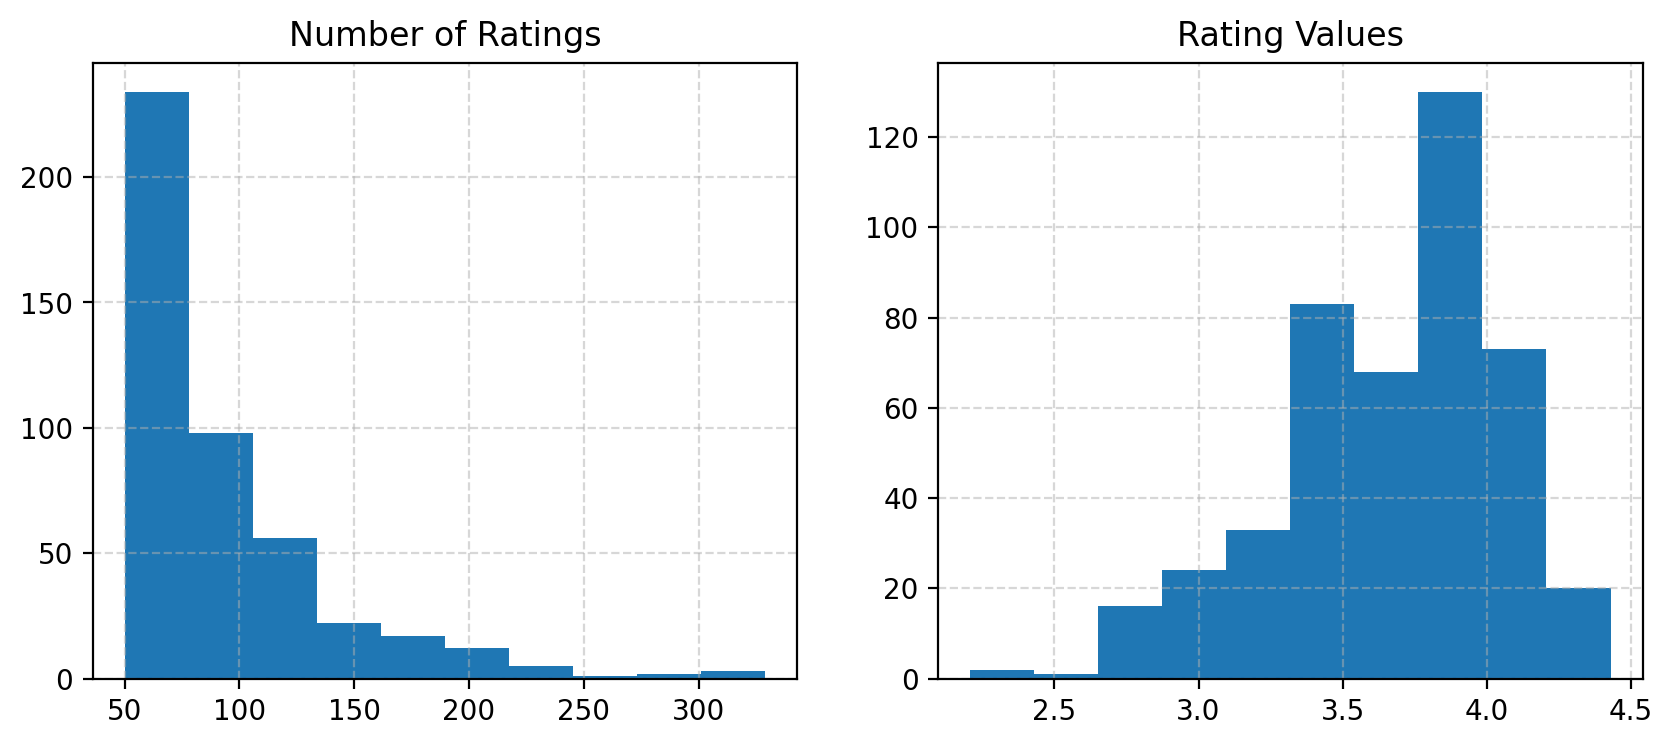

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Plot the histograms to visualize the distribution of number of ratings and average rating values
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].hist(ratings['title'].value_counts())
axs[0].set_title('Number of Ratings')
axs[1].hist(ratings.groupby('title')['rating'].mean())
axs[1].set_title('Average Ratings')
for ax in [axs[0], axs[1]]:
    ax.grid(linestyle='--', alpha=0.5)
plt.show()

#### 1.1 Pairing Function
Suggestions based on the most commonly **seen together** items: record every time two movies are watched by the same person and then count how often these pairs occur.

Look for all permutations of pairs: we consider all the arrangements, such that we collect every pair containing every movie (AB, AC, ..., BC, BD, ...).

In [88]:
from itertools import permutations

def find_movie_pairs(x):
    # Generate a df containing all the permutations for each user 
    pair_df = pd.DataFrame(permutations(x.values, 2), columns=['movie_a','movie_b'])
    return pair_df

# Apply the function to the dataset, considering only the movie titles
user_ratings_df = ratings.groupby('userId')['title'].apply(find_movie_pairs)
user_ratings_df.reset_index(drop=True, inplace=True) # clean the nested index

In [95]:
# Count how many times each pair occurs
combination_counts = user_ratings_df.groupby(['movie_a', 'movie_b']).value_counts()
# Convert to a dataframe and reset the index for easiness of reading
combination_counts_df = combination_counts.to_frame(name='size').reset_index()
combination_counts_df.sort_values('size', ascending=False, inplace=True)
combination_counts_df.head()

,movie_a,movie_b,size
71736,Forrest Gump (1994),"Shawshank Redemption, The (1994)",231
156852,"Shawshank Redemption, The (1994)",Forrest Gump (1994),231
142933,Pulp Fiction (1994),Forrest Gump (1994),230
71705,Forrest Gump (1994),Pulp Fiction (1994),230
157011,"Shawshank Redemption, The (1994)",Pulp Fiction (1994),222


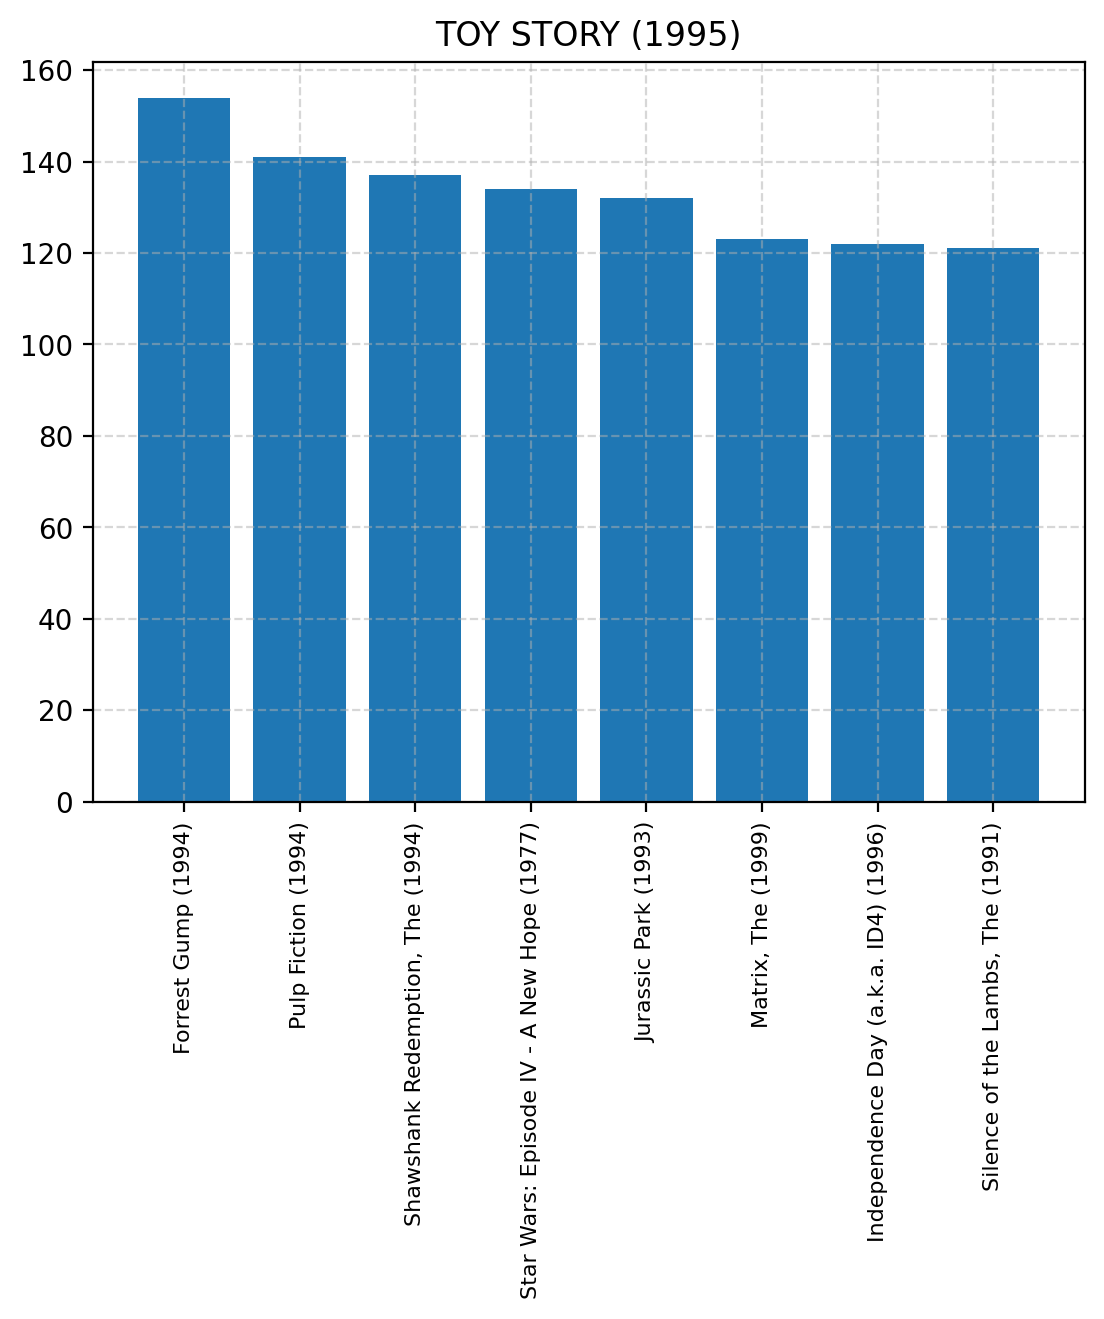

In [120]:
# We can now plot the most (8) likely pair for each movie of interest
def plot_pairs(df, title=''):
    title_df = df[df['movie_a'] == title][:8]
    plt.bar(x=title_df['movie_b'], height=title_df['size'])
    plt.title(title.upper())
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()

plot_pairs(combination_counts_df, 'Toy Story (1995)')